# Project Statistical Analysis

Karla y Mar

*Data Part Time Barcelona Dic 2019*

<img src="./img/5530085.jpeg" width="1000"> 

# 1. Importamos librería

In [129]:
import pandas as pd
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf
from datetime import datetime
from ipywidgets import interact
import ipywidgets as wdg
import numpy as np
import scipy.stats as sp
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import cartopy
warnings.filterwarnings('ignore')
import plotly.offline as off
import json
import requests
from pandas.io.json import json_normalize
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.optimize import curve_fit
cf.go_offline()

# 2. Importamos datos

## 2.1. API datos coronavirus a nivel mundial

In [91]:
url='https://api.covid19api.com/all'
response = requests.get(url, headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"})
result=response.json()
df_coronavirus_raw = pd.DataFrame()
df_coronavirus_raw = json_normalize(result)
df_coronavirus_raw.head()

,Country,Province,Lat,Lon,Date,Cases,Status
0,,,0.0,0.0,0001-01-01T00:00:00Z,0,
1,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,1,confirmed
2,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,recovered
3,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,deaths
4,Afghanistan,,33.0,65.0,2020-02-24T00:00:00Z,1,confirmed


## 2.2. Continents by country

In [92]:
df_continents = pd.read_csv('./data/concap.csv')
df_continents.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Somaliland,Hargeisa,9.550000,44.050000,NaN,Africa
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000,GS,Antarctica
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667,TF,Antarctica
3,Palestine,Jerusalem,31.766667,35.233333,PS,Asia
4,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe


## 2.3. Join corinavirus info and continent info

In [93]:
# Clean some countries before merge
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Brunei', 'Country']='Brunei Darussalam'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Czechia', 'Country']='Czech Republic'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Hong Kong SAR', 'Country']='Hong Kong'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Iran (Islamic Republic of)', 'Country']='Iran'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Korea, South', 'Country']='South Korea'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='North Macedonia', 'Country']='Macedonia'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Republic of Korea', 'Country']='North Korea'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Taiwan*', 'Country']='Taiwan'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='US', 'Country']='United States'

In [94]:
df_coronavirus_raw = df_coronavirus_raw.merge(df_continents, left_on='Country', right_on='CountryName', how='left')

## 2.4. Regional information

In [21]:
url='https://api.covid19tracking.narrativa.com/api/2020-03-24'
response = requests.get(url, headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"})
result=response.json()

In [45]:
print(result['dates'].values())

dict_values([{'countries': {'Afghanistan': {'name': 'Afghanistan', 'name_es': 'Afganistán', 'regions': [], 'today_confirmed': 74, 'today_deaths': 1, 'today_new_confirmed': 34, 'today_new_deaths': 0, 'today_new_open_cases': 34, 'today_new_recovered': 0, 'today_open_cases': 72, 'today_recovered': 1, 'today_vs_yesterday_confirmed': 0.8500000000000001, 'today_vs_yesterday_deaths': 0.0, 'today_vs_yesterday_open_cases': 0.894736842105263, 'today_vs_yesterday_recovered': 0.0, 'yesterday_confirmed': 40, 'yesterday_deaths': 1, 'yesterday_open_cases': 38, 'yesterday_recovered': 1}, 'Albania': {'name': 'Albania', 'name_es': 'Albania', 'regions': [], 'today_confirmed': 123, 'today_deaths': 5, 'today_new_confirmed': 19, 'today_new_deaths': 1, 'today_new_open_cases': 10, 'today_new_recovered': 8, 'today_open_cases': 108, 'today_recovered': 10, 'today_vs_yesterday_confirmed': 0.1826923076923077, 'today_vs_yesterday_deaths': 0.25, 'today_vs_yesterday_open_cases': 0.1020408163265305, 'today_vs_yesterda

In [60]:
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

df_repos=pd.DataFrame()
df_repos=json_normalize(flatten_json(result))
df_repos.head()

,dates_2020-03-24_countries_Afghanistan_name,dates_2020-03-24_countries_Afghanistan_name_es,dates_2020-03-24_countries_Afghanistan_today_confirmed,dates_2020-03-24_countries_Afghanistan_today_deaths,dates_2020-03-24_countries_Afghanistan_today_new_confirmed,dates_2020-03-24_countries_Afghanistan_today_new_deaths,dates_2020-03-24_countries_Afghanistan_today_new_open_cases,dates_2020-03-24_countries_Afghanistan_today_new_recovered,dates_2020-03-24_countries_Afghanistan_today_open_cases,dates_2020-03-24_countries_Afghanistan_today_recovered,...,total_today_recovered,total_today_vs_yesterday_confirmed,total_today_vs_yesterday_deaths,total_today_vs_yesterday_open_cases,total_today_vs_yesterday_recovered,total_yesterday_confirmed,total_yesterday_deaths,total_yesterday_open_cases,total_yesterday_recovered,updated_at
0,Afghanistan,Afganistán,74,1,34,0,34,0,72,1,...,106491,0.115104,0.109306,0.134665,0.06523,376807,16925,259912,99970,2020-03-25 17:20UTC


In [97]:
df_repos=pd.DataFrame()
l_list=dict()
n=0

for date_v in result.values():
    for countries_v in date_v.values():
        for country in countries_v.values():
            pdf_reposrint(json_normalize(dict(x))


# for k,v in result.items():
#     for k2,v2 in dict(v).items():
#         for k3,v3 in dict(v2).items():
#             for k3,v4 in dict(v3).items():
# #                 df_repos.append(list(v4), ignore_index=True)
# #                 list(v4)
# #                 json_normalize(dict(x))
#                 print(n)
#                 print(dict(v4))
#                 n=n+1
# df_repos.head()
#     list_developers = [list(filter(None,x)) for x in list_developers]

# df = pd.DataFrame([(k,k1,v1) for k,v in result.items() for k1,v1 in v.items()])


{'Afghanistan': {'name': 'Afghanistan', 'name_es': 'Afganistán', 'regions': [], 'today_confirmed': 74, 'today_deaths': 1, 'today_new_confirmed': 34, 'today_new_deaths': 0, 'today_new_open_cases': 34, 'today_new_recovered': 0, 'today_open_cases': 72, 'today_recovered': 1, 'today_vs_yesterday_confirmed': 0.8500000000000001, 'today_vs_yesterday_deaths': 0.0, 'today_vs_yesterday_open_cases': 0.894736842105263, 'today_vs_yesterday_recovered': 0.0, 'yesterday_confirmed': 40, 'yesterday_deaths': 1, 'yesterday_open_cases': 38, 'yesterday_recovered': 1}, 'Albania': {'name': 'Albania', 'name_es': 'Albania', 'regions': [], 'today_confirmed': 123, 'today_deaths': 5, 'today_new_confirmed': 19, 'today_new_deaths': 1, 'today_new_open_cases': 10, 'today_new_recovered': 8, 'today_open_cases': 108, 'today_recovered': 10, 'today_vs_yesterday_confirmed': 0.1826923076923077, 'today_vs_yesterday_deaths': 0.25, 'today_vs_yesterday_open_cases': 0.1020408163265305, 'today_vs_yesterday_recovered': 4.0, 'yesterd

AttributeError: 'str' object has no attribute 'values'

In [13]:
for i in result.items():
    print(i)
# result['dates']

('dates', {'2020-03-24': {'countries': {'Afghanistan': {'name': 'Afghanistan', 'name_es': 'Afganistán', 'regions': [], 'today_confirmed': 74, 'today_deaths': 1, 'today_new_confirmed': 34, 'today_new_deaths': 0, 'today_new_open_cases': 34, 'today_new_recovered': 0, 'today_open_cases': 72, 'today_recovered': 1, 'today_vs_yesterday_confirmed': 0.8500000000000001, 'today_vs_yesterday_deaths': 0.0, 'today_vs_yesterday_open_cases': 0.894736842105263, 'today_vs_yesterday_recovered': 0.0, 'yesterday_confirmed': 40, 'yesterday_deaths': 1, 'yesterday_open_cases': 38, 'yesterday_recovered': 1}, 'Albania': {'name': 'Albania', 'name_es': 'Albania', 'regions': [], 'today_confirmed': 123, 'today_deaths': 5, 'today_new_confirmed': 19, 'today_new_deaths': 1, 'today_new_open_cases': 10, 'today_new_recovered': 8, 'today_open_cases': 108, 'today_recovered': 10, 'today_vs_yesterday_confirmed': 0.1826923076923077, 'today_vs_yesterday_deaths': 0.25, 'today_vs_yesterday_open_cases': 0.1020408163265305, 'today

In [118]:
df_regions_raw = pd.DataFrame()
# df_coro_reg_raw = json_normalize(json_normalize(result).dates[0])
df_regions_raw = json_normalize(result)
# df_regions_raw.columns=[str.strip(x.lower()) for x in dfArticles.columns]
df_regions_raw.head()


,updated_at,dates.2020-03-10.countries.Afghanistan.name,dates.2020-03-10.countries.Afghanistan.name_es,dates.2020-03-10.countries.Afghanistan.regions,dates.2020-03-10.countries.Afghanistan.today_confirmed,dates.2020-03-10.countries.Afghanistan.today_deaths,dates.2020-03-10.countries.Afghanistan.today_new_confirmed,dates.2020-03-10.countries.Afghanistan.today_new_deaths,dates.2020-03-10.countries.Afghanistan.today_new_open_cases,dates.2020-03-10.countries.Afghanistan.today_new_recovered,...,total.today_open_cases,total.today_recovered,total.today_vs_yesterday_confirmed,total.today_vs_yesterday_deaths,total.today_vs_yesterday_open_cases,total.today_vs_yesterday_recovered,total.yesterday_confirmed,total.yesterday_deaths,total.yesterday_open_cases,total.yesterday_recovered
0,2020-03-24 12:50UTC,Afghanistan,Afganistán,[],5,0,1,0,1,0,...,99708,79737,0.095441,0.127246,0.152361,0.02905,170911,6900,86525,77486


In [186]:
#Datos de España
path = 'https://code.montera34.com:4443/numeroteca/covid19/-/raw/master/data/output/covid19-cases-uci-deaths-by-ccaa-spain-by-day-accumulated.csv'
df_spain_deceased = pd.read_csv(path, sep=',')
df_spain_deceased.head()

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
0,2020-02-27,1,Andalucía,Spain,8414240,1,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-28,1,Andalucía,Spain,8414240,6,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-29,1,Andalucía,Spain,8414240,8,0.10,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-01,1,Andalucía,Spain,8414240,12,0.14,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-02,1,Andalucía,Spain,8414240,12,0.14,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
print(df_spain_deceased.country.value_counts())
print(df_sp_it_fr_conf.country.value_counts())

Spain    570
Name: country, dtype: int64
Italia    651
Spain     532
France    420
Name: country, dtype: int64


In [187]:
#Datos de España, Italia y Francia
path = 'https://code.montera34.com:4443/numeroteca/covid19/-/raw/master/data/output/covid19-countries-regions-compile.csv'
df_sp_it_fr_conf = pd.read_csv(path, sep=',')
df_sp_it_fr_conf.head()

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
0,2020-02-27,1.0,Andalucía,Spain,8414240.0,1.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-28,1.0,Andalucía,Spain,8414240.0,6.0,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-29,1.0,Andalucía,Spain,8414240.0,8.0,0.10,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-01,1.0,Andalucía,Spain,8414240.0,12.0,0.14,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-02,1.0,Andalucía,Spain,8414240.0,12.0,0.14,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
#Datos de camas UCI
path = './data/ccaa_camas_uci_2017.csv'
df_camas_uci = pd.read_csv(path, sep=',')
df_camas_uci.head()

,cod_ine,CCAA,Públicos,Privados,Total
0,1,ANDALUCÍA,572,162,734
1,2,ARAGÓN,113,22,135
2,3,ASTURIAS,86,7,93
3,15,C. FORAL DE NAVARRA,46,19,65
4,5,CANARIAS,187,50,237


In [146]:
#Datos de mascarillas entregadas
path = './data/ccaa_covid19_mascarillas.csv'
df_camas_uci = pd.read_csv(path, sep=',')
df_camas_uci.head()

,fecha,cod_ine,CCAA,mascarillas_acumulado_desde_2020-03-10
0,2020-03-22,1.0,ANDALUCÍA,444083
1,2020-03-22,2.0,ARAGÓN,72455
2,2020-03-22,3.0,ASTURIAS,60229
3,2020-03-22,4.0,BALEARES,49476
4,2020-03-22,5.0,CANARIAS,124165


In [147]:
#Datos por rangos de edad
path = './data/nacional_covid19_rango_edad.csv'
df_camas_uci = pd.read_csv(path, sep=',')
df_camas_uci.head()

,fecha,rango_edad,sexo,casos_confirmados,hospitalizados,ingresos_uci,fallecidos
0,2020-03-23,0-9,ambos sexos,129,34,1,0
1,2020-03-23,10-19,ambos sexos,221,15,0,1
2,2020-03-23,20-29,ambos sexos,1285,183,8,4
3,2020-03-23,30-39,ambos sexos,2208,365,15,3
4,2020-03-23,40-49,ambos sexos,2919,663,40,9


In [27]:
df_coronavirus_raw[df_coronavirus_raw['Country']=='US']
# df_coronavirus_raw.head()

,Country,Province,Lat,Lon,Date,Cases,Status,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName


# 3. Data cleaning

## 3.1. Cases by country

### 3.1.1. Renombramos columnas y estandarizamos nombres

In [95]:
df_coronavirus_raw.columns = df_coronavirus_raw.columns.str.replace('[.]','_').str.lower()
df_coronavirus_raw = df_coronavirus_raw.rename(columns = {'lat':'latitude', 'lon':'longitude', 'capitalname':'capital', 
                                                         'capitallatitude':'capital_latitude', 'capitallongitude':'capital_longitude',
                                                         'countrycode':'country_code', 'continentname':'continent'})
df_coronavirus_raw.head()

,country,province,latitude,longitude,date,cases,status,countryname,capital,capital_latitude,capital_longitude,country_code,continent
0,,,0.0,0.0,0001-01-01T00:00:00Z,0,,NaN,NaN,NaN,NaN,NaN,NaN
1,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,1,confirmed,NaN,NaN,NaN,NaN,NaN,NaN
2,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,recovered,NaN,NaN,NaN,NaN,NaN,NaN
3,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,deaths,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,,33.0,65.0,2020-02-24T00:00:00Z,1,confirmed,Afghanistan,Kabul,34.516667,69.183333,AF,Asia


### 3.1.2. Eliminamos columnas duplicadas

In [97]:
df_coronavirus_raw.drop('countryname', axis=1, inplace=True)
df_coronavirus_raw.where(cond=df_coronavirus_raw['country']!="",inplace=True)

### 3.1.3. Clasificamos los paises entre China y resto del mundo

In [98]:
df_coronavirus_raw['class'] = np.where(df_coronavirus_raw.country.str.contains('China'), 'China', 'Other Countries')
df_coronavirus_raw['date'] = pd.to_datetime(df_coronavirus_raw['date'], format="%Y-%m-%dT%H:%M:%SZ")
l_index = ['class','continent','country', 'province', 'latitude','longitude', 'date']
df_coronavirus = pd.pivot_table(df_coronavirus_raw, values='cases', 
                index = l_index, columns=['status'],
                aggfunc=np.sum, fill_value=0).reset_index()
df_coronavirus.head()

status,class,continent,country,province,latitude,longitude,date,confirmed,deaths,recovered
0,China,Asia,China,Anhui,31.8257,117.226,2020-01-22,1,0,0
1,China,Asia,China,Anhui,31.8257,117.226,2020-01-23,9,0,0
2,China,Asia,China,Anhui,31.8257,117.226,2020-01-24,15,0,0
3,China,Asia,China,Anhui,31.8257,117.226,2020-01-25,39,0,0
4,China,Asia,China,Anhui,31.8257,117.226,2020-01-26,60,0,0


### 3.1.4. Obtenemos los totales por países y calculamos las estadísticas

- Los casos existentes se han calculado de la siguiente manera :    
         casos existentes = casos confirmados - fallecidos - recuperados
- La columna <CODE>'days_province_confirmed'</CODE> nos crea un contador a partir de los 100 casos confirmados.
- La columna <CODE>'estimated'</CODE> nos da una aproximación de los posibles casos que hay teniendo en cuanta la mortalidad.
         casos estimados = fallecidos * 99
- La columna <CODE>'days_ death'</CODE> nos crea un contador a partir de los 10 fallecimientos.

In [99]:
df_countries = df_coronavirus.groupby(['class','continent','country','date'])['confirmed','deaths', 'recovered'].agg('sum').reset_index()
df_countries['existing'] = df_countries.confirmed.fillna(0) -  df_countries.deaths.fillna(0) - df_countries.recovered.fillna(0)
df_countries['days_confirmed'] = df_countries[df_countries['confirmed']>100].groupby(['country']).cumcount()+1
df_countries['days_confirmed'] = df_countries['days_confirmed'].fillna(0).astype('int')
df_countries['days_death'] = df_countries[df_countries['deaths']>10].groupby(['country']).cumcount()+1
df_countries['days_death'] = df_countries['days_death'].fillna(0).astype('int')
df_countries['days_recovered'] = df_countries[df_countries['confirmed']>100].groupby(['country']).cumcount()+1
df_countries['days_recovered'] = df_countries['days_recovered'].fillna(0).astype('int')
df_countries['estimated'] = [confirmed*99 for confirmed in df_countries['confirmed']]
df_countries.head()

status,class,continent,country,date,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
0,China,Asia,China,2020-01-22,548,17,28,503,1,1,1,54252
1,China,Asia,China,2020-01-23,643,18,30,595,2,2,2,63657
2,China,Asia,China,2020-01-24,920,26,36,858,3,3,3,91080
3,China,Asia,China,2020-01-25,1406,42,39,1325,4,4,4,139194
4,China,Asia,China,2020-01-26,2075,56,49,1970,5,5,5,205425


### 3.1.5. Ordenamos columas

In [100]:
column_order = ['date', 'class', 'continent', 'country', 'confirmed','deaths', 'recovered', 'existing', 'days_confirmed', 'days_death','days_recovered','estimated']
df_countries = df_countries[column_order]
df_countries.head()

status,date,class,continent,country,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
0,2020-01-22,China,Asia,China,548,17,28,503,1,1,1,54252
1,2020-01-23,China,Asia,China,643,18,30,595,2,2,2,63657
2,2020-01-24,China,Asia,China,920,26,36,858,3,3,3,91080
3,2020-01-25,China,Asia,China,1406,42,39,1325,4,4,4,139194
4,2020-01-26,China,Asia,China,2075,56,49,1970,5,5,5,205425


## 3.2. Cases by regions

In [ ]:
https://api.covid19tracking.narrativa.com/api?date_from=2020-03-10&date_to=2020-03-17

# 4. Comparación de la evolución de casos entre dos países

## 4.1. Estadísticas de dos paises

In [101]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
cou_vars = list(df_countries['country'].unique())

def make_hist(country1='Italy', country2='Spain'):
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=(country1, country2))
    for x in range(0,len(col_vars)):
        df_filtered = df_countries[df_countries['country']==country1]
        fig.add_trace(go.Scatter( \
                      x = df_filtered['date'], \
                      y = df_filtered[col_vars[x]], \
                      mode = 'lines+markers',
                      name = f'{country1} - {col_vars[x].capitalize()}'),
                      row=1, col=1)
        df_filtered2 = df_countries[df_countries['country']==country2]
        fig.add_trace(go.Scatter( \
                      x = df_filtered2['date'], \
                      y = df_filtered2[col_vars[x]], \
                      mode = 'lines+markers',
                      name = f'{country2} - {col_vars[x].capitalize()}'),
                      row=1, col=2)
        
    fig.update_layout(height=500, width=1000, title_text=f'Evolución de casos {country1} vs. {country2}', title_x=0.5)
    fig.show()
                      
_= interact(make_hist, country1 = cou_vars, country2 = cou_vars)

interactive(children=(Dropdown(description='country1', index=127, options=('China', 'Algeria', 'Angola', 'Beni…

## 4.2. Comparación de la curva de evolución de dos paises

In [102]:
def make_hist(country1='Italy', country2='Spain'):
    nrows = 2
    ncols = nrows
    fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Total of {c} cases' for c in col_vars])
    for c in range(0,len(col_vars)):
        df_filtered = df_countries[df_countries['country']==country1]
        fig.add_trace(go.Scatter( \
                      x = df_filtered['days_confirmed'], \
                      y = df_filtered[col_vars[c]], \
                      mode = 'lines+markers',
                      name = f'{country1} - {col_vars[c].capitalize()}'),
                      row=int(c/nrows)+1, col=(c%ncols)+1)
        df_filtered2 = df_countries[df_countries['country']==country2]
        fig.add_trace(go.Scatter( \
                      x = df_filtered2['days_confirmed'], \
                      y = df_filtered2[col_vars[c]], \
                      mode = 'lines+markers',
                      name = f'{country2} - {col_vars[c].capitalize()}'),
                      row=int(c/nrows)+1, col=(c%ncols)+1)
        
    fig.update_layout(height=1000, width=1000, title_text=f'Evolución de casos {country1} vs. {country2}', title_x=0.5)
    fig.show()
                      
_= interact(make_hist, country1 = cou_vars, country2 = cou_vars)

interactive(children=(Dropdown(description='country1', index=127, options=('China', 'Algeria', 'Angola', 'Beni…

**Insights**: 
* Se puede ver un comportamiento distinto entre China y el resto del mundo, por lo que se han dividido las gráficas en estos dos grupos.
  * China: Un aumento muy claro de casos desde el inicio de la enfermedad hasta el 14 de febrero (con picos el 12, 13 y 14 de Febrero). A partir de allí las medidas tomadas por el gobierno de China comienzan a dar resutados y el número de casos que se recuperan sube exponencialmente. Asimismo los casos confirmados bajan diariamente lo que indica la remisión del virus. Sin embargo el virus ha dejado 3193 muetros en el territorio de China.
  * Resto del mundo: A partir del 14 de Febrero los casos en los demás paises comienzan a crecer exponencialmente. A partir del 10 de Marzo se dan crecimientos más altos que los días de crecimiento más altos de la enfermedad en China, por lo que se declara el grado de pandemia. Se puede ser además que si no se toman las medidas de contención necesarias y se sigue la misma curva de progresión de la enfermedad que en China (en el mejor de los casos) la enfermedad puede llegar a duplicar el número de casos confirmados en el mundo.

# 5. Suma acumulada de casos de coronavirus por país

##  Sumarizamos los casos para obtener los acumulados por país y por fecha

In [103]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
cou_vars = ['All']
cou_vars.extend(sorted(list(df_coronavirus['country'].unique())))

## Creamos un combobox con los países y diagramamos los casos confirmados, muertos, recuperados y existentes

In [104]:
def make_hist(Country): 
    nrows = 2
    ncols = nrows
    fig = make_subplots(rows = nrows, cols = ncols, subplot_titles=[f'Total of {c} cases' for c in col_vars])
    for c in range(0,len(col_vars)):
        if(Country=='All'):
            df_filtered = df_countries
        else:
            df_filtered = df_countries[df_countries['country']==Country]
        fig.add_trace(
            go.Bar(x = df_filtered['date'], \
                y = df_filtered[col_vars[c]], \
                name = col_vars[c].capitalize()),
                row=int(c/nrows)+1, col=(c%ncols)+1)
    fig.update_layout(height=1000, width=1000, title_text="Casos acumulados de coronavirus por país", title_x=0.5)
    fig.show()

_= interact(make_hist, Country = (cou_vars))

interactive(children=(Dropdown(description='Country', options=('All', 'Afghanistan', 'Albania', 'Algeria', 'An…

**Insights**: 
* Si seleccionamos la opción All, se puede ver el la composición de casos por país, donde hasta hace unos días el protagonista era China. A partir del 14 de Febrero la actividad del virus remite en China, pero se contafia al resto del mundo. Adicionalmente se puede ser que el ratio de muerte de la enfermedad es muy bajo.
* En España e Italia los casos han crecido exponencialmente desde Marzo.

# 6. Top 10 de los países más afectados por el coronavirus

In [123]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
options = ["Include China","Exclude China"]

def top_ten(Options, Tipo_indicador):
    fig = go.Figure()
    column = Tipo_indicador
    df_plot = fig_confirmed(Options, column=column)
    fig = px.bar(df_plot, x=column, y='country',  
        labels={column: f'{column.capitalize()} cases by country',
        'country':f'Top 10 countries with {column} cases'},
        animation_frame=df_plot.date.dt.strftime('%Y-%m-%d'), orientation='h').update_yaxes(categoryorder='total ascending')
    fig.update_layout(title_text=f"Evolution of {column} cases by country: Top 10", title_x=0.5)
    return fig.show()
        
def fig_confirmed(Options, column):
    if Options == "Include China":
        return(df_countries.groupby('date',group_keys=False)\
        .apply(lambda grp:grp.nlargest(n=int(10),columns=column).sort_index()).reset_index())
    else:       
        return(df_countries[df_countries['country']!="China"].groupby('date',group_keys=False)\
            .apply(lambda grp:grp.nlargest(n=int(10),columns=column).sort_index()).reset_index())

_= interact(top_ten, Options = options, Tipo_indicador = col_vars)

interactive(children=(Dropdown(description='Options', options=('Include China', 'Exclude China'), value='Inclu…

**Insights:**

En esta progresión de tiempo se puede ver el crecimiento de la expansión de virus en europa especialmente en Italia y España en Europa e Iran y Corea del Sur en el mes de Marzo. Antes de ello la cantidad de casos de concentraba en China.

# 7. Casos confirmados de coronavirus: Estadísticas

In [92]:
df_countries_top10 = df_countries.groupby('date',group_keys=False)\
            .apply(lambda grp:grp.nlargest(n=int(10),columns='confirmed').sort_index()).reset_index()
df_countries_top10.head()

status,index,date,class,continent,country,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered
0,615,2020-01-22,Other Countries,Asia,Hong Kong,0,0,0,0,0,0,0
1,834,2020-01-22,Other Countries,Asia,Japan,2,0,0,2,0,0,0
2,996,2020-01-22,Other Countries,Asia,Macau,1,0,0,1,0,0,0
3,1416,2020-01-22,Other Countries,Asia,South Korea,1,0,0,1,0,0,0
4,1523,2020-01-22,Other Countries,Asia,Taiwan,1,0,0,1,0,0,0


In [93]:
fig = px.box(df_countries_top10, y="confirmed", x='class', 
             labels={'confirmed': f'Confirmed cases of Coronavirus',
            'class':'Agrupation by countries: China vs. Rest of the world'},
             points="all")
fig.update_layout(title_text="Stats of confirmed cases: China vs. Rest of world", title_x=0.5)
fig.show()

**Insights:**

En este gráfico no se puede sacar muchos insights ya que la curva de tiempo de la evolución del virus en China está en un estado de descenso, mientras que en el resto del mundo está ascendiendo. Lo que sí se puede ver es que la gravedad de los casos en el mundo ya está superando a China y se deben estudiar en los próximos días la evolución en los países más afectados de forma separada. 

# 8. Geoplot: Casos informados de coronavirus por países

In [116]:
col_vars = ['confirmed','deaths', 'recovered']
scope_vars = ['World', 'USA', 'Europe', 'Asia', 'Africa', 'North America', 'South America']

df_countries_region = df_coronavirus.groupby(['country','date'])[col_vars].agg('sum').reset_index()

def make_scatter(scope): 
    fig = px.scatter_geo(df_coronavirus, lon = df_coronavirus['longitude'], lat = df_coronavirus['latitude'], #color="continent",
                     scope=scope.lower(),
                     hover_name=df_coronavirus['country'], 
                     size=df_coronavirus['confirmed'],
                     size_max=50,
                     animation_frame=df_coronavirus.date.dt.strftime('%Y-%m-%d'))  
    fig.update_layout(title_text="Evolución de casos confirmados a nivel mundial", title_x=0.5, margin_l=0)
    fig.show()

_= interact(make_scatter, scope = (scope_vars))

interactive(children=(Dropdown(description='scope', options=('World', 'USA', 'Europe', 'Asia', 'Africa', 'Nort…

**Insights:**

Hace un par de meses China era el protagonista mundial de este gráfico, sin embargo el panorama actual es distinto, ya que el virus se ha diseminado por toda Europa.

# 9.Estadística

## 9.1. Funciones

In [126]:
def hipotesis_result (pval, conf):
    
    """
    ************************************Contraste de hipótesis************************************
    
    Devuelve la decisión de rechazar o no la hipótesis nula dados el p-valor y el nivel de confianza.
    
    Input:
    * pval(float): P-valor. Probabilidad de que un valor sea posible dada una hipótesis nula cierta.
    * conf(float) : Nivel de confianza deseado.
    
    Output:
    * (str): Si se acepta o rechaza la H0 y los valores'pval' y 'conf' introducidos.
    
    ***********************************************************************************************
    
    """
    alpha = 1 - conf
    if pval <= alpha:
        return f'Se rechaza la hipótesis nula (H0). Nuestro p-valor {pval} es menor a nuestra α {round(alpha,2)}'
    else:
        return f'No se rechaza la hipótesis nula (H0). Nuestro p-valor {pval} es mayor a nuestra α {round(alpha,2)}'


    
def pearson_correlation (X, Y, conf):
    
    """
    ************************************Correlación de Pearson************************************
    
    Devuelve la decisión de rechazar o no la hipótesis nula dados el p-valor y el nivel de confianza.
    
    Input:
    * X: muestra 1
    * Y: muestra 2
    * conf : nivel de confianza
    
    Output:
    * stat, pval : Estadístico resultante de la correlación de Pearson y el p.valor.
    
    ***********************************************************************************************
    
    """
        
    stat, pval = stats.pearsonr(X,Y)
    return hipotesis_result(pval, conf)
    

def model_summary (x, y):
    
    from statsmodels.regression import linear_model as sm
    
    """
    ************************************Correlación de Pearson************************************
    
    Devuelve la sumarización de diferentes estadísticos.
    
    Input:
    * X: muestra 1
    * Y: muestra 2

    
    Output:
    * stat, pval : Listado de estadísticos.
    
    ***********************************************************************************************
    
    """
    model = sm.OLS(y.astype(float), y.astype(float)).fit()

    print(model.summary())
    

def linear_reg (x, y):
    linear_regression = LinearRegression()
    linear_regression.fit(x,y)
    y_pred = linear_regression.predict(x)
    sns.lmplot("X","Y", data = student_data)
    
def expon_distribution ():
    return 1 - stats.expon(1/10).cdf(15)
 
def log_distribution(x, a, b, c, d):
    return a/(d + b*np.exp(-c * x))

def t_test_features(s1, s2, conf, features=['confirmed','deaths', 'recovered', 'existing', 'estimated']):
    
    """
    La prueba 't de Student' se aplica cuando la población estudiada sigue una 
    distribución normal pero el tamaño muestral es demasiado pequeño como para 
    que el estadístico en el que está basada la inferencia esté normalmente 
    distribuido, utilizándose una estimación de la desviación típica en lugar del 
    valor real. Es utilizado en análisis discriminante.
    
    Calculate the T-test for the means of two independent samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the populations
    have identical variances by default.
    
    Args:
        s1 (dataframe): sample 1
        s2 (dataframe): sample 2
        features (list): an array of features to test
    
    Returns:
        dict: a dictionary of t-test scores for each feature where the feature name
        is the key and the p-value is the value
    """
    
    results = {}
    
    # Your code here
    
    for feat in features:
        c = sp.ttest_ind(s1[feat], s2[feat])[1]
        results[feat] = hipotesis_result(c,conf)
    
    return results

In [127]:
def poly_reg (country, days_predict):
    
    """
    La regresión polinómica es una predicción de una variable de 
    respuesta cuantitativa a partir de una variable predictora 
    cuantitativa, donde la relación se modela como una función 
    polinomial de orden n.
    
    Args:
        country: país a predecir
        days_predict: hasta que día

    
    Returns:
        plot con la predicción.
        
    """
    
    selection = df_countries[df_countries['country'] == country]
    X = selection['days_confirmed'].values
    y = selection['deaths'].values
    mymodel = np.poly1d(np.polyfit(X, y, 3))
    myline = np.linspace(1, days_predict, 100)
    plt.plot(myline, mymodel(myline))
    plt.scatter(X,y)
    plt.show()

In [162]:
def log_reg (country, days_predict):
    
    """
    La regresión polinómica es una predicción de una variable de 
    respuesta cuantitativa a partir de una variable predictora 
    cuantitativa, donde la relación se modela como una función 
    polinomial de orden n.
    
    Args:
        country: país a predecir
        days_predict: hasta que día

    
    Returns:
        plot con la predicción.
        
    """
    
    selection = df_countries[df_countries['country'] == country]
    X = selection['days_confirmed'].values
    Y = selection['confirmed'].values
    
    popt, pcov = curve_fit(func, X, Y)
    x_days_predict = np.arange(0,days_predict,1)
    plt.plot(x_days_predict, func(x_days_predict, *popt), label='Model', linewidth=3)
    plt.plot(selection['days_confirmed'], selection['confirmed'], 'o', label='Confirmed')
    plt.plot(selection['days_death'], selection['deaths'], 'o', label='deaths')
    plt.plot(selection['days_recovered'], selection['recovered'], 'o', label='recovered')
    plt.plot(selection['days_confirmed'], selection['existing'], 'o', label='existing')
    plt.legend()
    plt.xlabel('Number of Days')
    plt.ylabel('Number of Cases')
    plt.grid('on')
    plt.show()

## 9.1. España vs Italia

In [124]:
corona_spain = df_countries[df_countries['country'] == "Spain"]
corona_spain = corona_spain[corona_spain['days_confirmed']>=1]
corona_it = df_countries[df_countries['country'] == "Italy"]
corona_it = corona_it[corona_it['days_confirmed']>=1]
corona_spain.head()

status,date,class,continent,country,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
3780,2020-03-02,Other Countries,Europe,Spain,120,0,2,118,1,0,1,11880
3781,2020-03-03,Other Countries,Europe,Spain,165,1,2,162,2,0,2,16335
3782,2020-03-04,Other Countries,Europe,Spain,222,2,2,218,3,0,3,21978
3783,2020-03-05,Other Countries,Europe,Spain,259,3,2,254,4,0,4,25641
3784,2020-03-06,Other Countries,Europe,Spain,400,5,2,393,5,0,5,39600


In [130]:
t_test_features(corona_spain,corona_it, 0.95)

{'confirmed': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.15276583662951174 es mayor a nuestra α 0.05',
 'deaths': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.05240802942803716 es mayor a nuestra α 0.05',
 'recovered': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.10231793729197025 es mayor a nuestra α 0.05',
 'existing': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.1826508723517132 es mayor a nuestra α 0.05',
 'estimated': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.15276583662951174 es mayor a nuestra α 0.05'}

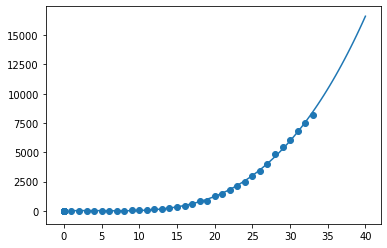

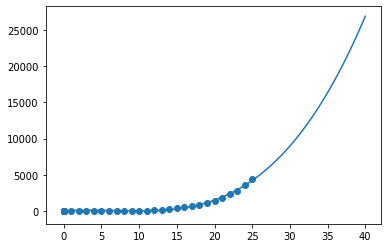

In [133]:
poly_reg("Italy", 40)
poly_reg("Spain", 40)

## 9.2. Usando una función logarítmica

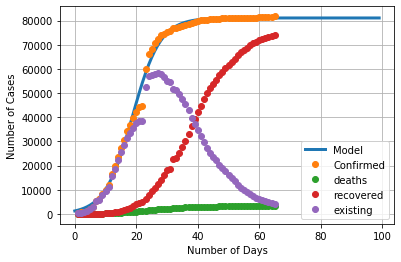

In [172]:
log_reg("China", 100)

## 9.3.Otros lo están haciendo peor?

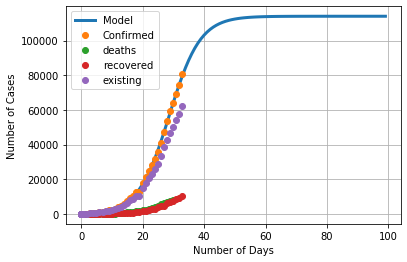

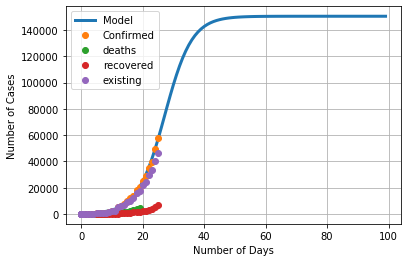

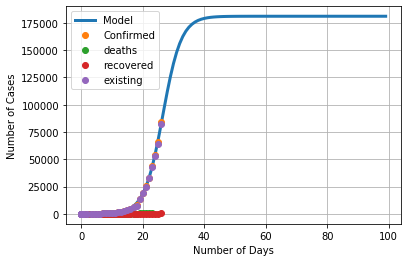

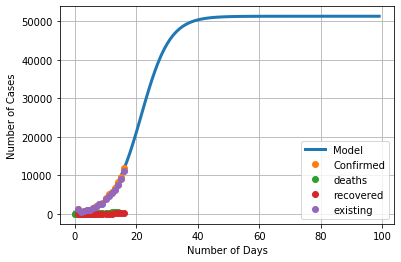

In [173]:
log_reg("Italy", 100)
log_reg("Spain", 100)
log_reg("United States", 100) #Flipo
log_reg("United Kingdom", 100) #Casi tan mal

In [185]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#@title SEIR Model with Social Distancing { run: "auto" }

#@markdown Reproduction number
R0 = widgets.FloatSlider(min=0.9, max=5, step=0.1, value=2.4)
#@markdown Disease periods in days
t_incubation = widgets.FloatSlider(min=1, max=14, step=0.1, value=14)
t_infective  = widgets.FloatSlider(min=1, max=14, step=0.1, value=3.3)
#@markdown Population Size
N = widgets.IntSlider(min=1000, max=350000, step=1000, value=89000)
#@markdown Initial number exposed
n = widgets.IntSlider(min=0, max=100, step=1, value=45)
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = widgets.FloatSlider(min=0, max=30, step=0.1, value=2)
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = widgets.IntSlider(min=0, max=100, step=1, value=80)

def hola(R0, t_incubation, t_infective, N, n, t_social_distancing, u_social_distancing):
    # initial number of infected and recovered individuals
    e_initial = n/N
    i_initial = 0.00
    r_initial = 0.00
    s_initial = 1 - e_initial - i_initial - r_initial

    alpha = 1/t_incubation
    gamma = 1/t_infective
    beta = R0*gamma

    def step(t):
        return 1 if t >= 7*t_social_distancing else 0

    # SEIR model differential equations.
    def deriv(x, t, u, alpha, beta, gamma):
        s, e, i, r = x
        dsdt = -(1-u*step(t)/100)*beta * s * i
        dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
        didt = alpha * e - gamma * i
        drdt =  gamma * i
        return [dsdt, dedt, didt, drdt]

    t = np.linspace(0, 210, 210)
    x_initial = s_initial, e_initial, i_initial, r_initial
    s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
    s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

    # plot the data
    fig = plt.figure(figsize=(12, 10))
    ax = [fig.add_subplot(311, axisbelow=True), 
          fig.add_subplot(312)]

    pal = sns.color_palette()

    ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
    ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
    ax[0].set_xlabel('Weeks following Initial Campus Exposure')
    ax[0].set_xlim(0, t[-1]/7)
    ax[0].set_ylim(0, N)
    ax[0].legend([
        'Susceptible', 
        'Exposed/no symptoms', 
        'Infectious/symptomatic',
        'Recovered'], 
        loc='best')
    ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
    ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
    ax[0].annotate("Start of social distancing",
        (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
        arrowprops=dict(arrowstyle='->'))
    ax[0].annotate("Herd Immunity without social distancing",
        (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
        arrowprops=dict(arrowstyle='->'))

    ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
    ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
    ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
    ax[1].set_xlim(0, t[-1]/7)
    ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
    ax[1].set_xlabel('Weeks following Initial Campus Exposure')
    ax[1].legend([
        'Infective/Symptomatic', 
        'Exposed/Not Sympotomatic'],
        loc='upper right')
    ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

    y0 = N*(e0 + i0)
    k0 = np.argmax(y0)
    ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

    y = N*(e + i)
    k = np.argmax(y)
    ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

    for a in ax:
        a.xaxis.set_major_locator(plt.MultipleLocator(5))
        a.xaxis.set_minor_locator(plt.MultipleLocator(1))
        a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        a.grid(True)

    plt.tight_layout()
    
interact(hola,R0=R0, t_incubation=t_incubation, t_infective=t_infective, N=N, n=n, t_social_distancing=t_social_distancing, 
         u_social_distancing=u_social_distancing);

interactive(children=(FloatSlider(value=2.4, description='R0', max=5.0, min=0.9), FloatSlider(value=14.0, desc…

In [198]:
print(df_spain_deceased.date.max())
print(df_sp_it_fr_conf[df_sp_it_fr_conf.country=='Spain'].date.max())


2020-03-27
2020-03-25


In [203]:
df_sp_it_fr_conf[df_sp_it_fr_conf['date']=='2020-03-25']

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
27,2020-03-25,1.0,Andalucía,Spain,8414240.0,3010.0,35.77,116.0,1.38,113.0,1.34,71.0,8.44
55,2020-03-25,2.0,Aragón,Spain,1319291.0,907.0,68.75,75.0,5.68,40.0,3.03,4.0,3.03
83,2020-03-25,3.0,Asturias,Spain,1022800.0,779.0,76.16,29.0,2.84,25.0,2.44,35.0,34.22
111,2020-03-25,4.0,Baleares,Spain,1149460.0,562.0,48.89,40.0,3.48,13.0,1.13,28.0,24.36
139,2020-03-25,10.0,C. Valenciana,Spain,5003769.0,2616.0,52.28,198.0,3.96,143.0,2.86,44.0,8.79
167,2020-03-25,5.0,Canarias,Spain,2153389.0,657.0,30.51,43.0,2.00,21.0,0.98,15.0,6.97
195,2020-03-25,6.0,Cantabria,Spain,581078.0,510.0,87.77,18.0,3.10,14.0,2.41,12.0,20.65
223,2020-03-25,7.0,Castilla y León,Spain,2399548.0,2940.0,122.52,170.0,7.08,165.0,6.88,213.0,88.77
251,2020-03-25,8.0,Castilla-La Mancha,Spain,2032863.0,2780.0,136.75,210.0,10.33,263.0,12.94,71.0,34.93
279,2020-03-25,9.0,Cataluña,Spain,7675217.0,9937.0,129.47,781.0,10.18,516.0,6.72,1274.0,165.99
